In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import pickle
import os
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
# prepare data for lstms
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_steps = 24
n_features = 7

In [5]:
dataset = pd.read_csv('../inputFile/modelInput/jlco0000st.csv')
y_train_dataset = dataset['Arousal'][n_steps:]
dataset = dataset.drop(columns=['Time','FileName','Valence','Arousal'])

test_dataset = pd.read_csv('../inputFile/modelInput/sentences/allFileCombineSentenceP.csv')
y_test_dataset = test_dataset['Arousal'][n_steps:]
test_dataset = test_dataset.drop(columns=['Time','Valence','Arousal'])

print(test_dataset.shape)
print(dataset.shape)
dataset


(1127890, 7)
(6708, 7)


,RMS(dB),F0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5
0,-71.713486,270.898251,-699.80646,28.912216,25.352512,21.115572,15.291195
1,-35.781930,189.933902,-589.86100,137.286930,56.127340,16.534332,15.156424
2,-34.623253,271.101014,-428.87006,161.527480,-5.255958,13.078750,-34.103554
3,-32.723373,288.888249,-401.31445,156.727330,-59.630970,-37.159626,-42.873610
4,-26.622677,265.787166,-314.31980,167.580570,-110.440020,-22.299570,-49.224373
...,...,...,...,...,...,...,...
6703,-47.064190,174.181843,-645.92804,135.531460,53.727020,23.638506,17.807636
6704,-48.884243,160.915282,-521.86540,-8.869608,10.255712,74.059100,-31.448784
6705,-46.795920,159.051490,-522.88530,39.255730,-77.956040,57.261450,20.647556
6706,-51.281616,182.202926,-672.47876,113.576645,42.719840,24.430153,40.927890


In [55]:

# load dataset
values = dataset.values
test_values = test_dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
test_scaled = scaler.fit_transform(test_values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps, 1)
test_reframed = series_to_supervised(test_scaled, n_steps, 1)
print(reframed.shape)
print(test_reframed.shape)
reframed

(6684, 175)
(1127866, 175)


,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var1(t-23),var2(t-23),var3(t-23),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
24,0.066472,0.883593,0.143335,0.325372,0.671362,0.497958,0.553561,0.620374,0.559736,0.314630,...,0.602924,0.644516,0.440182,0.279671,0.673110,0.356642,0.579890,0.552032,0.541355,0.471870
25,0.620374,0.559736,0.314630,0.639718,0.793832,0.475425,0.552749,0.638235,0.884404,0.565454,...,0.552032,0.541355,0.471870,0.033199,0.250761,0.161331,0.317783,0.645658,0.461802,0.524569
26,0.638235,0.884404,0.565454,0.710028,0.549553,0.458428,0.255835,0.667523,0.955553,0.608385,...,0.645658,0.461802,0.524569,0.672518,0.842433,0.281185,0.605913,0.940249,0.656990,0.567248
27,0.667523,0.955553,0.608385,0.696105,0.333164,0.211320,0.202974,0.761568,0.863149,0.743923,...,0.940249,0.656990,0.567248,0.756509,0.250764,0.613789,0.691733,0.551591,0.379156,0.462544
28,0.761568,0.863149,0.743923,0.727586,0.130966,0.284412,0.164695,0.654475,0.759368,0.440599,...,0.551591,0.379156,0.462544,0.827685,0.803437,0.773711,0.708866,0.156507,0.257762,0.320436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6703,0.420779,0.073494,0.263839,0.635780,0.703034,0.522709,0.512139,0.436038,0.503881,0.227949,...,0.609719,0.367708,0.648170,0.446452,0.496727,0.227277,0.634626,0.784280,0.510368,0.568729
6704,0.436038,0.503881,0.227949,0.610845,0.719356,0.584683,0.768367,0.452853,0.518063,0.379761,...,0.784280,0.510368,0.568729,0.418395,0.443661,0.420567,0.215784,0.611283,0.758372,0.271837
6705,0.452853,0.518063,0.379761,0.590208,0.735536,0.654309,0.465638,0.436420,0.497168,0.349351,...,0.611283,0.758372,0.271837,0.450588,0.436206,0.418978,0.355374,0.260238,0.675750,0.585846
6706,0.436420,0.497168,0.349351,0.590582,0.535540,0.562584,0.658281,0.417876,0.450975,0.416278,...,0.260238,0.675750,0.585846,0.381439,0.528812,0.185911,0.570945,0.740476,0.514262,0.708086


In [56]:
# split into train and test sets
values = reframed.values
test_values = test_reframed.values
# train = values
# test = test_values
n_train_hours = 6030
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [57]:
# split into input and outputs
n_obs = (n_steps + 1) * n_features
# train_X, train_y = train[:, :n_obs], y_train_dataset
# test_X, test_y = test[:, :n_obs], y_test_dataset
train_X, train_y = train[:, :n_obs], y_train_dataset[0:n_train_hours]
test_X, test_y = test[:, :n_obs], y_train_dataset[n_train_hours:]
print(train_X.shape, len(train_X), train_y.shape)

(6030, 175) 6030 (6030,)


In [58]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps + 1, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps + 1, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6030, 25, 7) (6030,) (654, 25, 7) (654,)


Epoch 1/50
603/603 - 5s - loss: 0.1962 - mae: 0.3621 - val_loss: 0.1980 - val_mae: 0.3918
Epoch 2/50
603/603 - 4s - loss: 0.1938 - mae: 0.3693 - val_loss: 0.1762 - val_mae: 0.3697
Epoch 3/50
603/603 - 4s - loss: 0.1754 - mae: 0.3461 - val_loss: 0.1569 - val_mae: 0.3497
Epoch 4/50
603/603 - 4s - loss: 0.1526 - mae: 0.3177 - val_loss: 0.1369 - val_mae: 0.3281
Epoch 5/50
603/603 - 4s - loss: 0.1263 - mae: 0.2862 - val_loss: 0.1205 - val_mae: 0.3075
Epoch 6/50
603/603 - 3s - loss: 0.1104 - mae: 0.2649 - val_loss: 0.1111 - val_mae: 0.2945
Epoch 7/50
603/603 - 4s - loss: 0.1039 - mae: 0.2509 - val_loss: 0.1073 - val_mae: 0.2870
Epoch 8/50
603/603 - 4s - loss: 0.1018 - mae: 0.2447 - val_loss: 0.1025 - val_mae: 0.2777
Epoch 9/50
603/603 - 4s - loss: 0.1029 - mae: 0.2445 - val_loss: 0.0979 - val_mae: 0.2688
Epoch 10/50
603/603 - 3s - loss: 0.1034 - mae: 0.2442 - val_loss: 0.0957 - val_mae: 0.2647
Epoch 11/50
603/603 - 4s - loss: 0.1030 - mae: 0.2425 - val_loss: 0.0945 - val_mae: 0.2621
Epoch 12

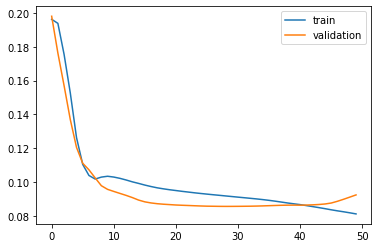

In [59]:
# design network
model = keras.Sequential()
model.add(layers.LSTM(49, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0005), metrics=['mae'])
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=8, validation_split = 0.2, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [60]:
# make a prediction
yhat = model.predict(test_X)
# invert scaling for forecast
inv_yhat = yhat
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
inv_y = y_train_dataset[n_train_hours:]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print(inv_yhat.shape, inv_y.shape)

Test RMSE: 0.183
(654,) (654,)


In [61]:
from sklearn.metrics import r2_score
r2_score(inv_y, inv_yhat)

0.5664717189553081

In [62]:
pred_test_list = [i for i in inv_yhat]
submission = pd.DataFrame({'Arousal' : inv_y, 'Prediction' : pred_test_list})


654 (654,)


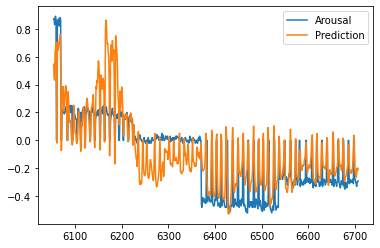

In [63]:
print(len(pred_test_list), inv_y.shape)
submission.loc[1:, ['Arousal', 'Prediction']].plot()
submission.to_csv('submission.csv', index=False)

In [64]:
correlation = submission.corr(method='pearson')
print(correlation)

             Arousal  Prediction
Arousal     1.000000    0.783493
Prediction  0.783493    1.000000


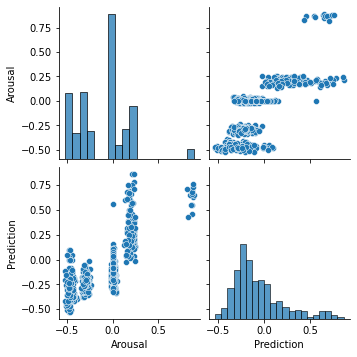

In [65]:
d0 = submission[['Arousal', 'Prediction']]
sns.pairplot(d0, kind="scatter")
plt.show()